<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/2C.%20Feature%20selection%20experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 Housekeeping**

### **1.1 Load libraries**

In [1]:
#basic libraries
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 200)

### **1.2 Load data**

In [3]:
train_labels = pd.read_csv('../data/train/labels.csv')
train_values = pd.read_csv('../data/train/features.csv', parse_dates = ['date_recorded' ],  na_values = [0, '0'])
test_values = pd.read_csv('../data/test/test.csv', parse_dates = ['date_recorded' ] , na_values = [0, '0'])
cleaned_df = pd.read_csv('cleaned_df.csv')
cleaned_df = cleaned_df.drop('Unnamed: 0', axis=1)


/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/201987825.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  cleaned_df = pd.read_csv('cleaned_df.csv')


In [4]:
#merge train values and train labels to single dataset
train= pd.merge(train_labels , train_values, on='id')

#concatenate train and test for data visualization
raw = pd.concat([train, test_values])

In [5]:
train_set = cleaned_df [cleaned_df ["id"].isin(train_values["id"])]
test_set =  cleaned_df  [cleaned_df ["id"].isin(test_values["id"])]

In [6]:
#cleaned dataframe where the majority of missing data is already imputed
# missing data can remain in features that I did not use in my final submission so I will impute these by the mean and mode

#create a list of numerical and categorical columns that contain missing data
numerical = ['num_private', 'amount_tsh', 'population', 'construction_year', 'gps_height', 'longitude']
categorical = ['scheme_name', 'installer', 'funder', 'scheme_management', 'public_meeting', 'permit', 'public_meeting', 'subvillage']

#impute numerical columns by the mean
for col in numerical:
  train_set[col] = train_set[col].fillna(train_set[col].mean())

#and categorical columns by the mode
for col in categorical:
  train_set[col] = train_set[col].fillna(train_set[col].mode()[0])


/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/2273196462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[col] = train_set[col].fillna(train_set[col].mean())
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/2273196462.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[col] = train_set[col].fillna(train_set[col].mode()[0])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/2273196462.py:14: SettingWithCopyWarning: 
A value is trying t

In [7]:
#create a list of all categorical features
categorical_cols = [cname for cname in train_set.columns if
                    train_set[cname].dtype == "object"]

# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  train_set[col] = le.fit_transform(train_set[col])

train_set = train_set.drop('district_code',axis=1)

/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/1392565685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[col] = le.fit_transform(train_set[col])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/1392565685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set[col] = le.fit_transform(train_set[col])
/var/folders/vg/953jt4190_x2bp1n7tcvzfpr0000gn/T/ipykernel_22066/1392565685.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

In [8]:
#fully encoded and imputed dataframe
train_set.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59399 entries, 0 to 59398
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59399 non-null  int64  
 1   status_group           59399 non-null  int64  
 2   amount_tsh             59399 non-null  float64
 3   date_recorded          59399 non-null  int64  
 4   funder                 59399 non-null  int64  
 5   installer              59399 non-null  int64  
 6   latitude               59399 non-null  float64
 7   wpt_name               59399 non-null  int64  
 8   num_private            59399 non-null  float64
 9   basin                  59399 non-null  int64  
 10  subvillage             59399 non-null  int64  
 11  region                 59399 non-null  int64  
 12  region_code            59399 non-null  int64  
 13  lga                    59399 non-null  int64  
 14  ward                   59399 non-null  int64  
 15  pu

### **1.3 Custom functions**

In [11]:
#calculate variance inflation factor
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [12]:
def feature_importances (model, title):
  model.fit(X, y)
  features= X.columns
  importances = np.round(model.feature_importances_,3) 
  indices = np.argsort(importances)
  num_features = len(features)
  fig, ax = plt.subplots(figsize=(10,10)) 
  plt.barh(range(num_features), importances[indices[-num_features:]],  align='center', color =  '#66c2a5')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.title('Feature Importance' + title)
plt.show()

# 2 Pearson's correlation

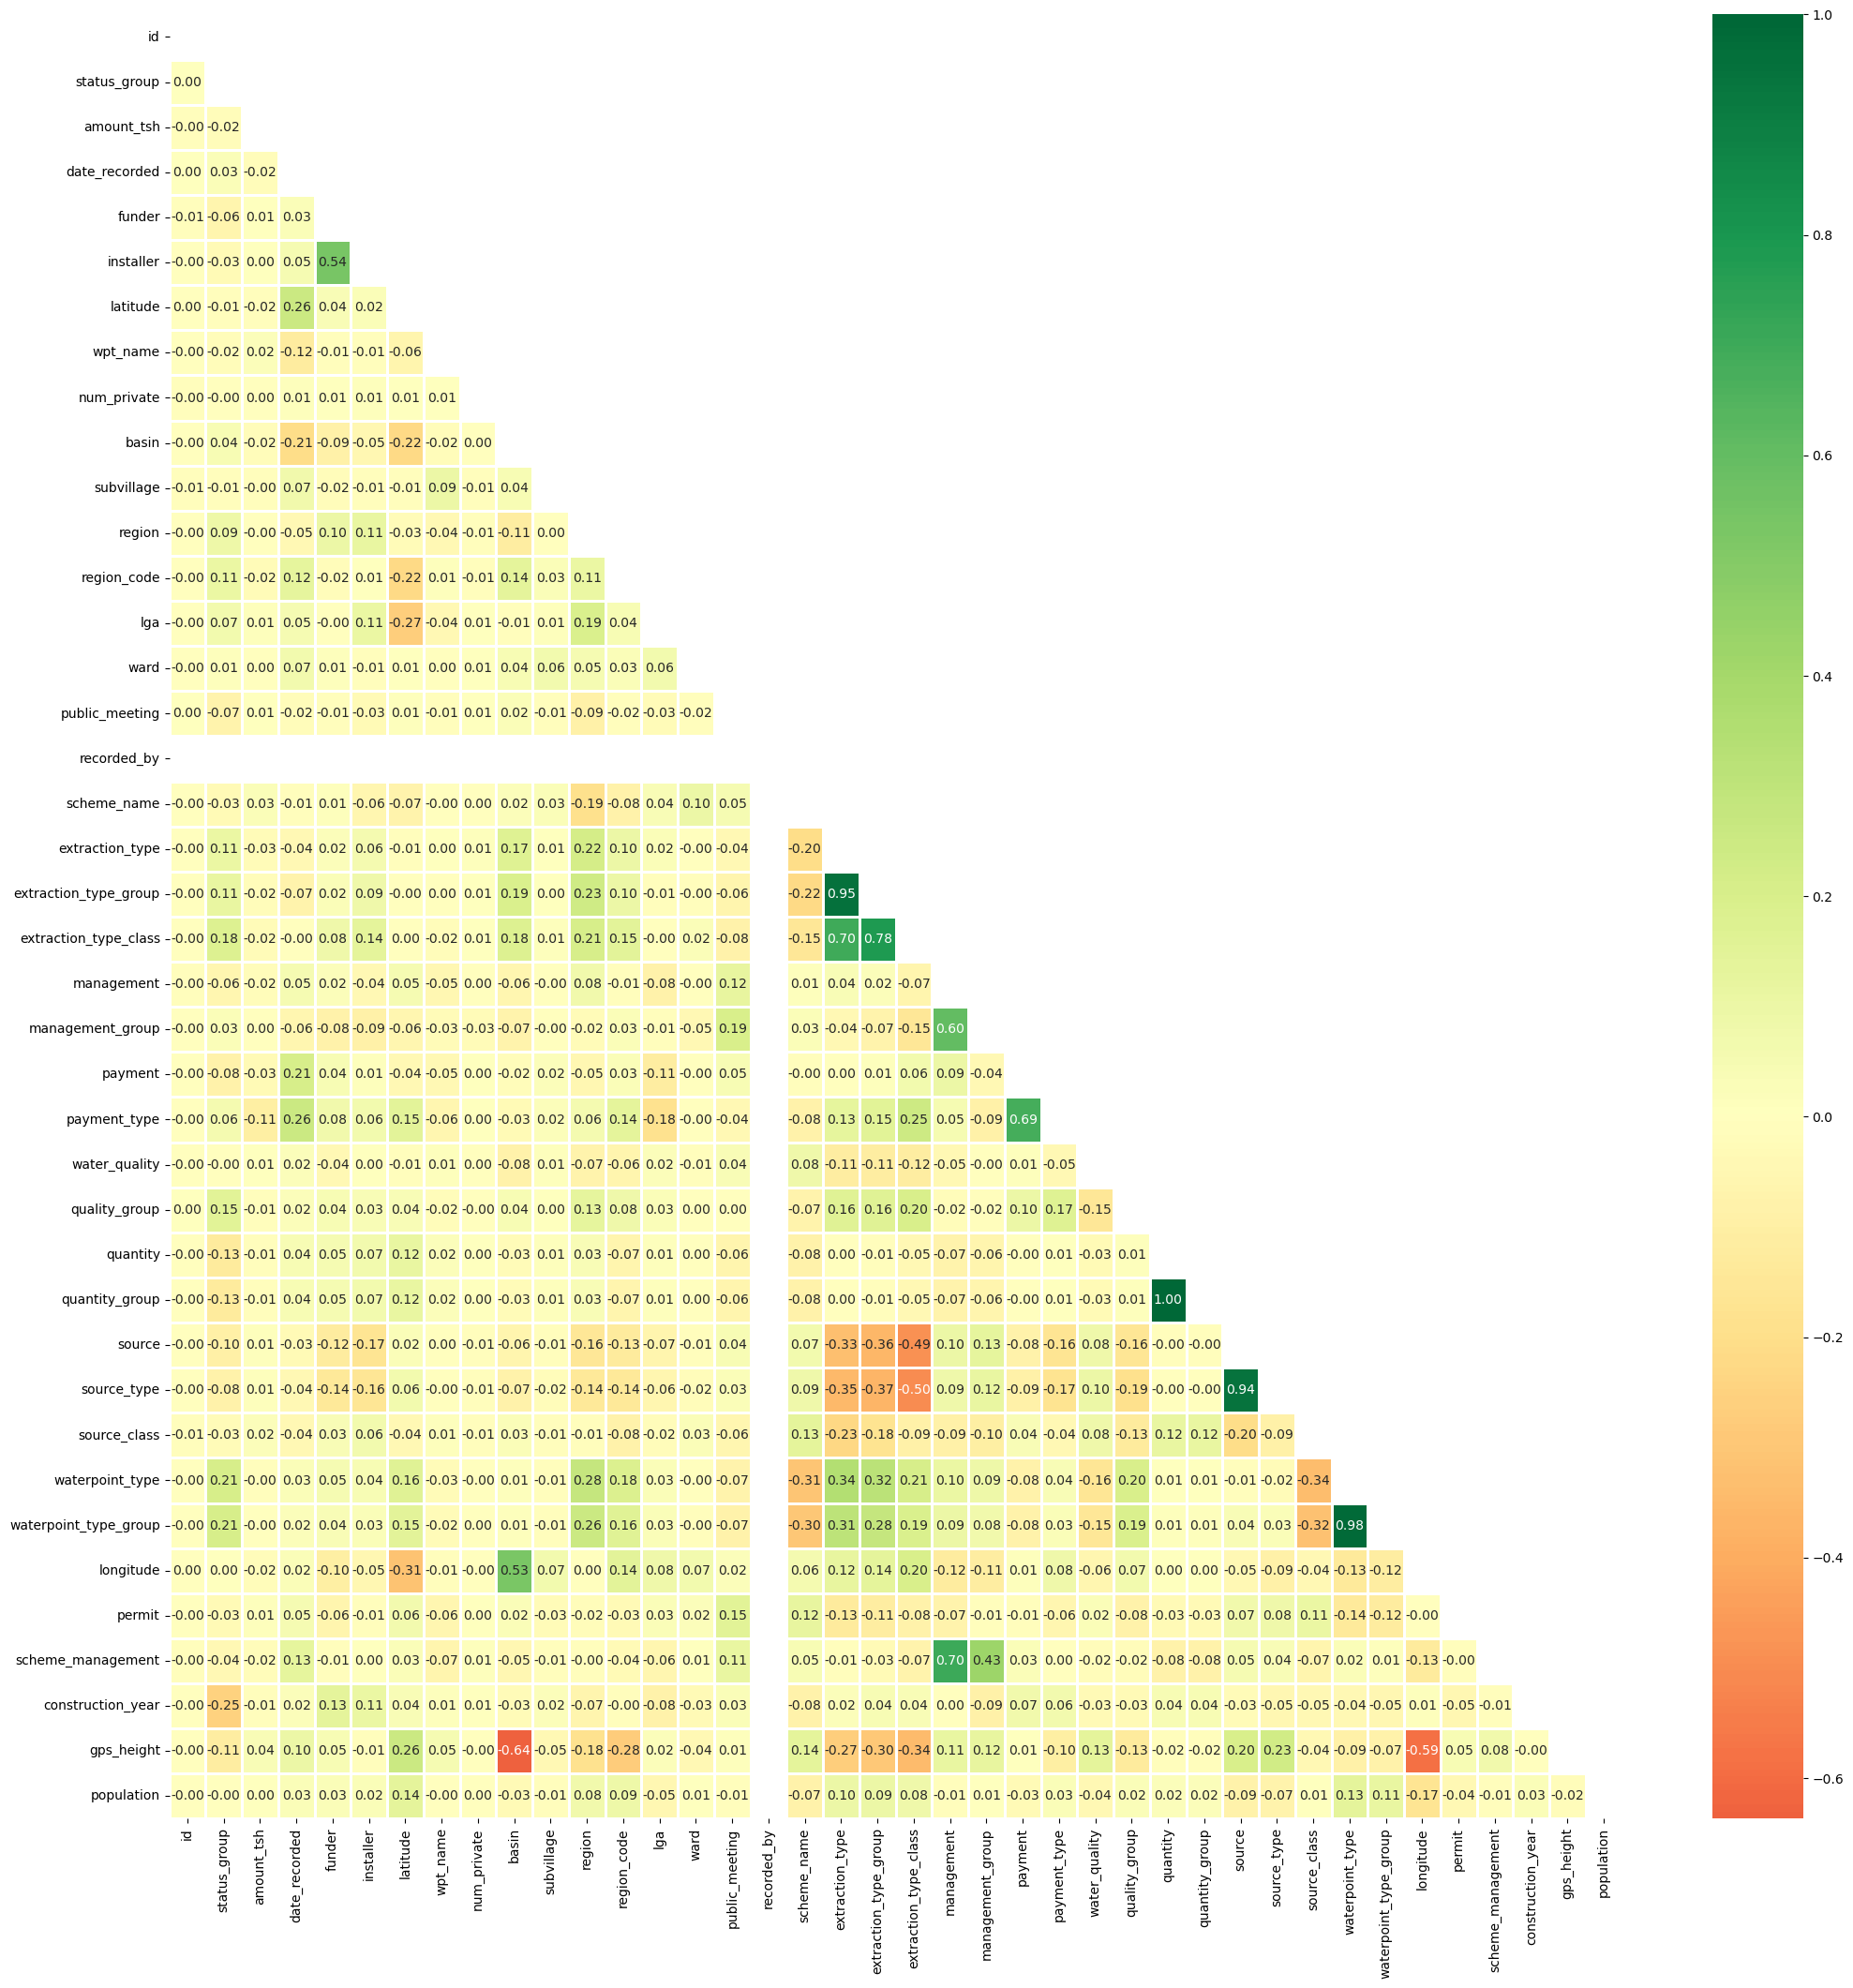

In [13]:
# Create the correlation matrix
corr_mean = train_set.corr(method = 'pearson')

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mean, dtype=bool))

# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(25,25)) 
ax = sns.heatmap(corr_mean, mask=mask, cmap= "RdYlGn", center=0, linewidths=1, annot=True, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_xticklabels())
plt.show()

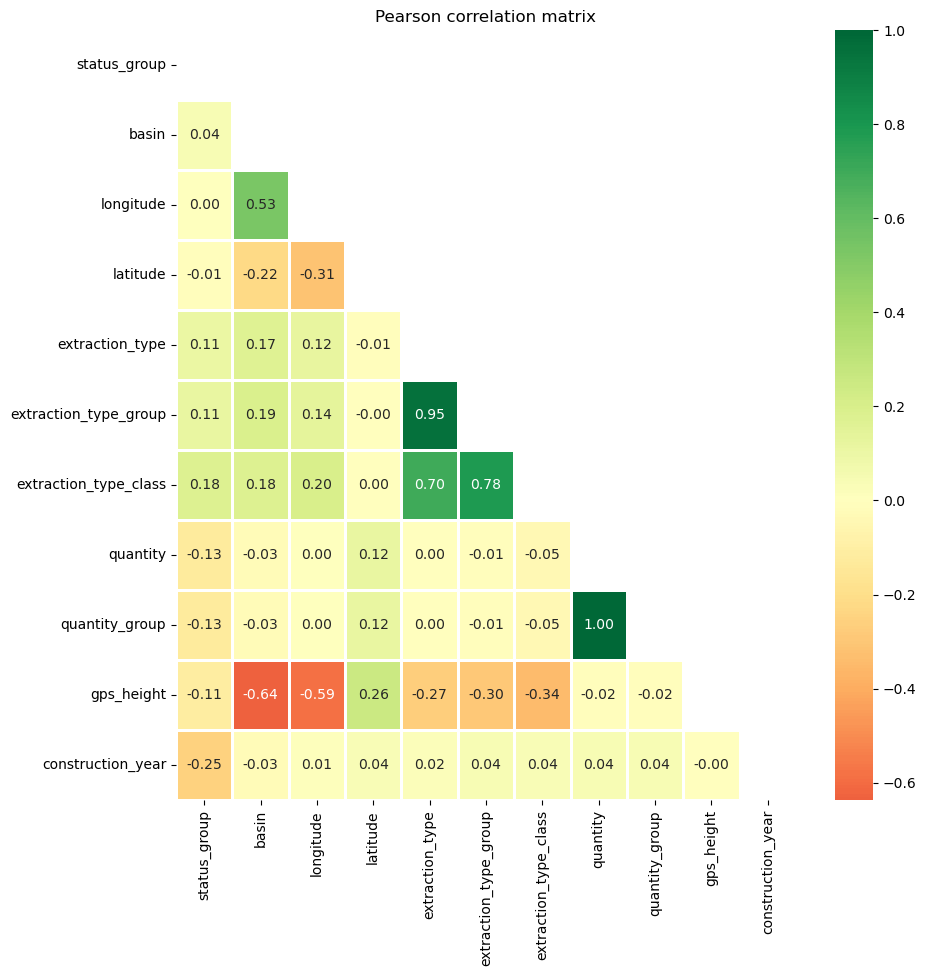

In [14]:
# Create the correlation matrix
variables = ['status_group', 'basin', 'longitude', 'latitude', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'quantity', 'quantity_group', 'gps_height', 'construction_year']
corr_mean = train_set[variables].corr(method = 'pearson')

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mean, dtype=bool))

# Add the mask to the heatmap
fig, ax = plt.subplots(figsize=(10,10)) 
ax = sns.heatmap(corr_mean, mask=mask, cmap= "RdYlGn", center=0, linewidths=1, annot=True, fmt=".2f")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
ax.set_title('Pearson correlation matrix')
plt.show()

This correlation matrix confirms what we already saw during EDA, some features are very similar. Waterpoint type and waterpoint type group have a correlation of 0.98 and quantity and quantity group have a correlation of 1. You can see similar patterns in the management, payment and extraction features. Pearson correlation only looks at pairwise relationships...

#**3 Multicollinearity**

In [15]:
vif_df =calc_vif(train_set)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head(10)

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
28,quantity_group,inf
27,quantity,inf
37,construction_year,599.489920
34,longitude,398.087736
29,source,117.050978
32,waterpoint_type,116.969388
33,waterpoint_type_group,114.010175
30,source_type,48.431573
25,water_quality,44.843300
18,extraction_type,39.708911


In [16]:
#drop high VIF features
train_set2 = train_set.drop('quantity_group', axis=1)
vif_df =calc_vif(train_set2)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
36,construction_year,599.489920
33,longitude,398.087736
28,source,117.050978
31,waterpoint_type,116.969388
32,waterpoint_type_group,114.010175


In [17]:
#drop high VIF features
train_set3 = train_set2.drop([ 'construction_year', 'longitude'], axis=1)
vif_df =calc_vif(train_set3)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
31,waterpoint_type,113.431433
32,waterpoint_type_group,111.961310
28,source,104.461576
29,source_type,46.023762
18,extraction_type,39.606303


In [18]:
#drop high VIF features
train_set4 = train_set3.drop([  'waterpoint_type', 'source'], axis=1)
vif_df =calc_vif(train_set4)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
18,extraction_type,39.092271
21,management,38.761486
19,extraction_type_group,35.792094
25,water_quality,33.803242
32,scheme_management,31.936997


In [19]:
#drop high VIF features
train_set5 = train_set4.drop([  'extraction_type'], axis=1)
vif_df =calc_vif(train_set5)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
20,management,38.749718
24,water_quality,33.730335
31,scheme_management,31.900276
21,management_group,22.428249
15,public_meeting,12.433479


In [20]:
#drop high VIF features
train_set6 = train_set5.drop([  'management'], axis=1)
vif_df =calc_vif(train_set6)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
23,water_quality,33.608780
30,scheme_management,19.541859
20,management_group,17.416247
15,public_meeting,12.433434
8,num_private,10.829087


In [21]:
#drop high VIF features
train_set7 = train_set6.drop([  'water_quality'], axis=1)
vif_df =calc_vif(train_set7)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
29,scheme_management,19.430001
20,management_group,17.336946
15,public_meeting,12.072767
8,num_private,10.604129
23,quality_group,9.916460


In [22]:
#drop high VIF features
train_set8 = train_set7.drop([  'scheme_management'], axis=1)
vif_df =calc_vif(train_set8)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
20,management_group,13.499160
15,public_meeting,11.983815
8,num_private,10.515824
23,quality_group,9.892775
29,gps_height,9.374290


In [23]:
#drop high VIF features
train_set9 = train_set8.drop([  'management_group'], axis=1)
vif_df =calc_vif(train_set9)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
15,public_meeting,10.981106
8,num_private,10.487076
22,quality_group,9.840018
28,gps_height,8.839948
21,payment_type,8.009621


In [24]:
#drop high VIF features
train_set10 = train_set9.drop([  'public_meeting'], axis=1)
vif_df =calc_vif(train_set10)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
8,num_private,10.329466
21,quality_group,9.653861
27,gps_height,8.561824
20,payment_type,8.009018
4,funder,6.797879


In [25]:
#drop high VIF features
train_set11 = train_set10.drop([  'num_private'], axis=1)
vif_df =calc_vif(train_set11)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
20,quality_group,9.560503
26,gps_height,8.213971
19,payment_type,7.973076
4,funder,6.785616
16,extraction_type_group,6.549878


In [26]:
#drop high VIF features
train_set12 = train_set11.drop([  'quality_group'], axis=1)
vif_df =calc_vif(train_set12)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
25,gps_height,8.006042
19,payment_type,7.852665
4,funder,6.762621
16,extraction_type_group,6.549872
6,latitude,6.281298


In [27]:
#drop high VIF features
train_set13 = train_set12.drop([  'gps_height'], axis=1)
vif_df =calc_vif(train_set13)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
19,payment_type,7.841622
4,funder,6.600676
16,extraction_type_group,6.482789
6,latitude,6.275326
5,installer,5.538272


In [28]:
#drop high VIF features
train_set14 = train_set13.drop([  'payment_type'], axis=1)
vif_df =calc_vif(train_set14)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
4,funder,6.576089
16,extraction_type_group,6.480303
6,latitude,6.142771
5,installer,5.525805
20,source_type,5.142020


In [29]:
#drop high VIF features
train_set15 = train_set14.drop([  'funder'], axis=1)
vif_df =calc_vif(train_set15)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
15,extraction_type_group,6.473631
5,latitude,6.106958
19,source_type,5.141097
16,extraction_type_class,5.051373
11,lga,4.714110


In [30]:
#drop high VIF features
train_set16 = train_set15.drop([  'extraction_type_group'], axis=1)
vif_df =calc_vif(train_set16)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
5,latitude,6.083086
18,source_type,5.128623
11,lga,4.713557
9,region,4.471730
20,waterpoint_type_group,4.407154


In [31]:
#drop high VIF features
train_set17 = train_set16.drop([  'latitude'], axis=1)
vif_df =calc_vif(train_set17)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
17,source_type,5.055276
8,region,4.434247
19,waterpoint_type_group,4.360443
3,date_recorded,4.193980
11,ward,4.180278


In [32]:
#drop high VIF features
train_set18 = train_set17.drop([  'source_type'], axis=1)
vif_df =calc_vif(train_set18)
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df

/Users/filip/miniconda3/envs/dsml/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,variables,VIF
8,region,4.418183
3,date_recorded,4.167273
11,ward,4.158816
10,lga,4.130960
18,waterpoint_type_group,4.123452
7,subvillage,4.042460
6,basin,3.905587
4,installer,3.782722
5,wpt_name,3.744506
16,quantity,3.683191


# **4 Model performance**

### **4.1 No Feature selection**

Accuracy: 0.813 (0.005)


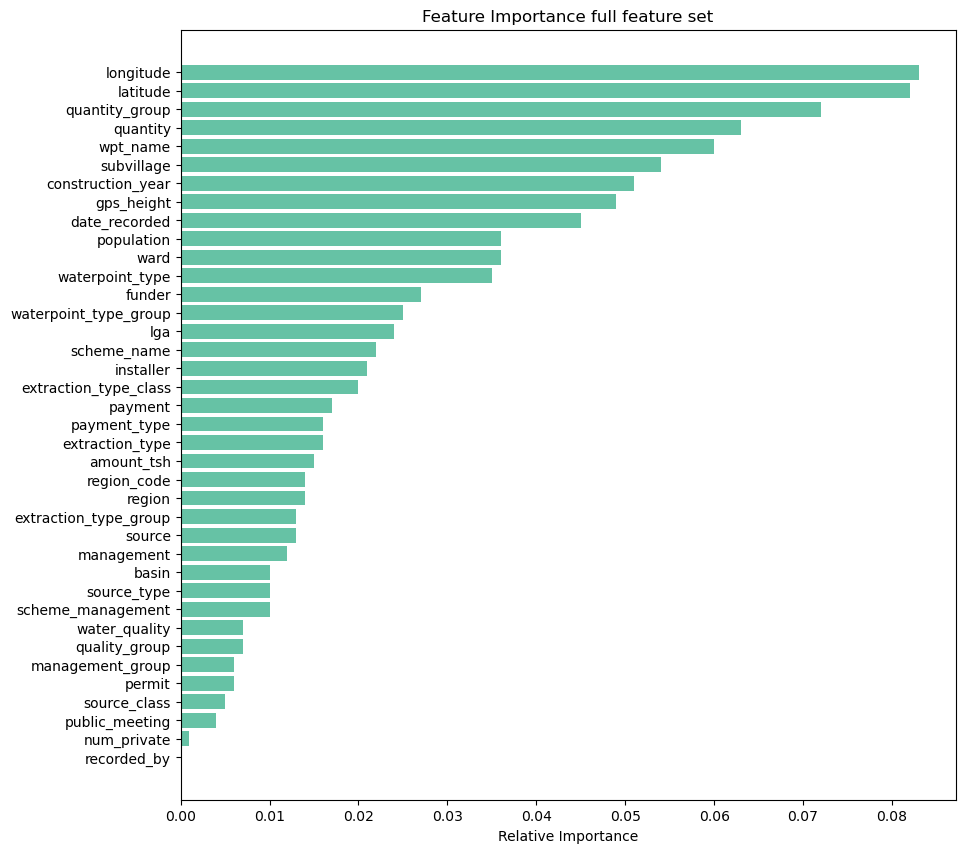

In [33]:
#define X and y varaibles
X = train_set.drop(['status_group', 'id'],axis=1)
y = train_set['status_group']

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances (rf, " full feature set")

### 4.2 VIF

Accuracy: 0.797 (0.005)


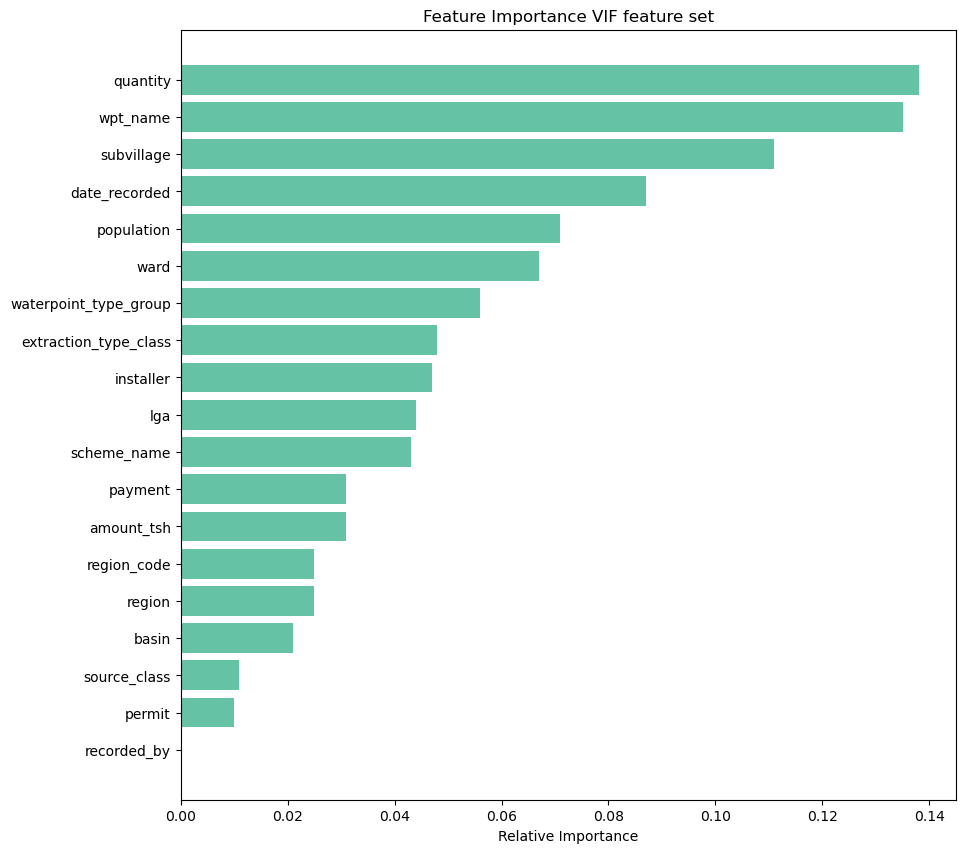

In [34]:
#define X and y varaibles
X = train_set[['amount_tsh', 'date_recorded', 'installer', 'wpt_name', 'basin', 'subvillage', 'region', 'region_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_class',
              'payment', 'quantity', 'source_class', 'waterpoint_type_group', 'permit', 'population']]
y = train_set['status_group']

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances (rf, " VIF feature set")


### **4.3 Manual feature selection**

Based on EDA I identified what features to keep and which ones to drop. Of course I had some feature engineering in mind (e.g. I would drop construction year, but creat a age feature). Let's just roughly compare how my manual feature selection compares to the VIF feature selection.

In [35]:
#some multicollinearity is left in my manual dataframe
vif_df =calc_vif(train_set.drop(['amount_tsh', 'date_recorded',  'extraction_type_group', 'lga', 'management', 'management_group',
                    'num_private', 'payment', 'source_class', 'source_type', 'quality_group', 'quantity_group', 'ward',
                    'waterpoint_type_group', 'wpt_name', 'scheme_name', 'subvillage', 'recorded_by', 'id', 'status_group'],axis=1))
vif_df = vif_df.sort_values('VIF', ascending = False)
vif_df.head()

,variables,VIF
17,construction_year,512.794727
14,longitude,351.382462
10,water_quality,43.888917
16,scheme_management,16.237742
12,source,13.769107


Accuracy: 0.808 (0.005)


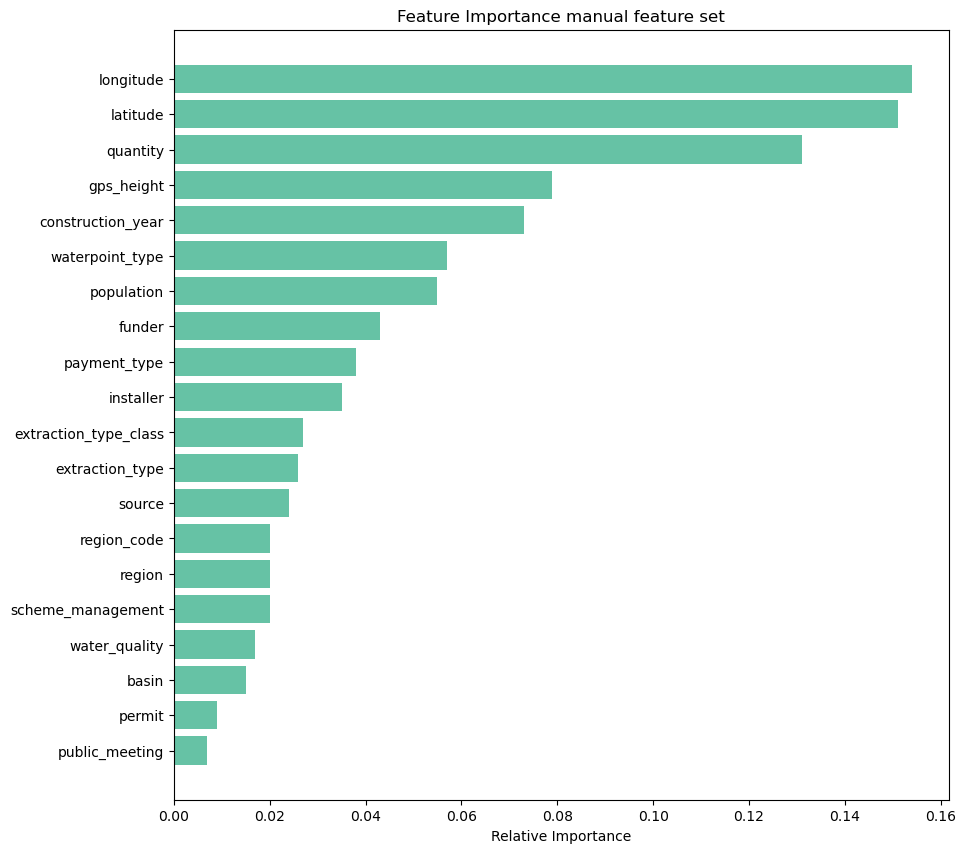

In [36]:
#define X and y varaibles
X = train_set.drop(['amount_tsh', 'date_recorded',  'extraction_type_group', 'lga', 'management', 'management_group',
                    'num_private', 'payment', 'source_class', 'source_type', 'quality_group', 'quantity_group', 'ward',
                    'waterpoint_type_group', 'wpt_name', 'scheme_name', 'subvillage', 'recorded_by', 'id', 'status_group'],axis=1)
y = train_set['status_group']

#instantiate model and cross_validation
rf = RandomForestClassifier(random_state =42)
cv = KFold(n_splits=10, shuffle = True,  random_state=1)

#perform cross-validaton
n_scores = cross_val_score(rf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#plot feature importance
feature_importances (rf, " manual feature set")


### 4.4 RFEC

In [37]:
#define X and y varaibles
X = train_set.drop(['status_group', 'id'],axis=1)
y = train_set['status_group']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42)

rf = RandomForestClassifier(random_state =42)
rfecv = RFECV(estimator=rf, step=1, cv=5,scoring='accuracy', verbose = 1,  min_features_to_select=15) 

#transform
rfecv.fit(X_train, y_train)
rfecv.transform(X_train)

#predict
y_pred = rfecv.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % (accuracy))

Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 fe

In [38]:
#let's check what features were dropped at each iteration
support = rfecv.support_.tolist()
ranking = rfecv.ranking_.tolist()
columns = X_train.columns.tolist()

d = {'Feature':columns,'Support': support, 'Ranking': ranking}  
score_df = pd.DataFrame(d)
score_df  = score_df .sort_values( 'Ranking', ascending = True)
score_df

,Feature,Support,Ranking
0,amount_tsh,True,1
20,management_group,True,1
21,payment,True,1
22,payment_type,True,1
23,water_quality,True,1
24,quality_group,True,1
25,quantity,True,1
19,management,True,1
26,quantity_group,True,1
28,source_type,True,1


Only three features were dropped when using RFECV....